In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置英文字体
# plt.rcParams['font.sans-serif'] = ['Times New Roman']

# 检查GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 读取数据，指定编码为utf-8-sig
X = pd.read_csv("E:/comorbidity/models/multi_features/emotion_sentiment_results.csv", encoding='utf-8-sig')  
y = pd.read_excel("E:/comorbidity/models/multi_features/Y.xlsx")  


# 2. 查看y的数据，假设标签列名为 '标签'
y = y['标签']

# 3. 标签编码（Label Encoding）
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 将标签转换为整数
print(y_encoded)


# 4. 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# #考虑到之前的特征都是标准化后的，所以这里不需要再标准化
# X_scaled = X.values

# 5. 划分训练集、验证集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 6. 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# 7. 创建数据加载器
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 8. 定义DNN模型 - 防过拟合优化版
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        # 简化网络结构，减少参数
        self.layer1 = nn.Linear(input_size, hidden_size // 2)  # 减少隐藏层大小
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)  # 添加批归一化
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # 适中的dropout
        self.layer2 = nn.Linear(hidden_size // 2, hidden_size // 4)  # 进一步减少
        self.bn2 = nn.BatchNorm1d(hidden_size // 4)
        self.dropout2 = nn.Dropout(0.4)  # 递增dropout
        self.layer3 = nn.Linear(hidden_size // 4, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.layer2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.layer3(out)
        return out

# 设置随机种子函数
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 训练和评估函数
def train_and_evaluate(seed):
    set_random_seed(seed)
    
    # 重新初始化模型
    model = DNN(input_size, hidden_size, num_classes).to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # 训练历史记录
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    patience = 6
    counter = 0
    best_val_acc = 0.0
    num_epochs = 50
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 创建进度条
        progress_bar = tqdm(train_loader, desc=f'运行{seed} Epoch {epoch+1:2d}/{num_epochs}')
        
        for inputs, labels in progress_bar:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 更新进度条
            progress_bar.set_postfix({'Loss': f'{loss.item():.3f}', 'Acc': f'{100.*correct/total:.1f}%'})
        
        progress_bar.close()
        
        # 计算训练指标
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # 验证集评估
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_pred = torch.max(val_outputs, 1)
            val_correct = val_pred.eq(y_val_tensor).sum().item()
            val_acc = 100. * val_correct / y_val_tensor.size(0)
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 早停检查
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), f'best_dnn_emotion_{seed}.pth')
        else:
            counter += 1
            if counter >= patience:
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load(f'best_dnn_emotion_{seed}.pth'))
    
    # 测试集评估
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)
        y_pred_proba = torch.softmax(outputs, dim=1).cpu().numpy()
    
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    # 计算weighted指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.preprocessing import label_binarize
    
    accuracy = accuracy_score(y_test_np, y_pred_np)
    precision = precision_score(y_test_np, y_pred_np, average='weighted')
    recall = recall_score(y_test_np, y_pred_np, average='weighted')
    f1 = f1_score(y_test_np, y_pred_np, average='weighted')
    
    # 计算weighted AUC
    y_test_bin = label_binarize(y_test_np, classes=list(range(num_classes)))
    auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_weighted,
        'history': history,
        'y_pred': y_pred_np,
        'y_pred_proba': y_pred_proba,
        'seed': seed
    }

# 初始化模型参数
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(label_encoder.classes_)

# 运行10次实验
print("开始10次独立实验...")
results = []
for i in range(10):
    print(f"运行第{i+1}次实验 (seed={42+i})...")
    result = train_and_evaluate(42+i)
    results.append(result)
    print(f"第{i+1}次: 准确率={result['accuracy']:.4f}, F1={result['f1']:.4f}")

# 计算统计结果
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
stats = {}

for metric in metrics:
    values = [r[metric] for r in results]
    stats[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

# 输出最终结果
print("\n" + "="*50)
print("最终结果 (平均值±标准差)")
print("="*50)
print(f"准确率: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
print(f"精准率: {stats['precision']['mean']:.4f} ± {stats['precision']['std']:.4f}")
print(f"召回率: {stats['recall']['mean']:.4f} ± {stats['recall']['std']:.4f}")
print(f"F1值: {stats['f1']['mean']:.4f} ± {stats['f1']['std']:.4f}")
print(f"AUC值: {stats['auc']['mean']:.4f} ± {stats['auc']['std']:.4f}")

# 保存最后一次实验的预测结果用于后续可视化
final_result = results[-1]
y_pred = final_result['y_pred']
y_pred_proba = final_result['y_pred_proba']
y_test = y_test_tensor.cpu().numpy()
history = final_result['history']


使用设备: cuda:0
[2 1 1 ... 3 0 1]
开始10次独立实验...
运行第1次实验 (seed=42)...


运行42 Epoch 16/50: 100%|██████████| 447/447 [00:02<00:00, 204.86it/s, Loss=1.225, Acc=67.9%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第1次: 准确率=0.6894, F1=0.6285
运行第2次实验 (seed=43)...


运行43 Epoch 10/50: 100%|██████████| 447/447 [00:01<00:00, 229.60it/s, Loss=0.688, Acc=67.7%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第2次: 准确率=0.6883, F1=0.6271
运行第3次实验 (seed=44)...


运行44 Epoch 13/50: 100%|██████████| 447/447 [00:01<00:00, 225.19it/s, Loss=0.958, Acc=67.8%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第3次: 准确率=0.6893, F1=0.6285
运行第4次实验 (seed=45)...


运行45 Epoch 10/50: 100%|██████████| 447/447 [00:01<00:00, 231.85it/s, Loss=1.102, Acc=67.7%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第4次: 准确率=0.6889, F1=0.6303
运行第5次实验 (seed=46)...


运行46 Epoch 11/50: 100%|██████████| 447/447 [00:02<00:00, 220.59it/s, Loss=0.875, Acc=67.9%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第5次: 准确率=0.6876, F1=0.6308
运行第6次实验 (seed=47)...


运行47 Epoch 10/50: 100%|██████████| 447/447 [00:01<00:00, 232.42it/s, Loss=1.321, Acc=67.8%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第6次: 准确率=0.6872, F1=0.6263
运行第7次实验 (seed=48)...


运行48 Epoch 28/50: 100%|██████████| 447/447 [00:02<00:00, 187.54it/s, Loss=1.086, Acc=68.0%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第7次: 准确率=0.6885, F1=0.6286
运行第8次实验 (seed=49)...


运行49 Epoch 18/50: 100%|██████████| 447/447 [00:02<00:00, 214.52it/s, Loss=0.781, Acc=67.9%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第8次: 准确率=0.6892, F1=0.6276
运行第9次实验 (seed=50)...


运行50 Epoch 13/50: 100%|██████████| 447/447 [00:01<00:00, 233.87it/s, Loss=0.945, Acc=67.8%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第9次: 准确率=0.6894, F1=0.6271
运行第10次实验 (seed=51)...


运行51 Epoch  8/50: 100%|██████████| 447/447 [00:01<00:00, 257.98it/s, Loss=0.900, Acc=67.6%]
d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


第10次: 准确率=0.6890, F1=0.6271

最终结果 (平均值±标准差)
准确率: 0.6887 ± 0.0007
精准率: 0.6226 ± 0.0013
召回率: 0.6887 ± 0.0007
F1值: 0.6282 ± 0.0014
AUC值: 0.7638 ± 0.0019


使用设备: cuda:0
[2 1 1 ... 3 0 1]
加载模型: E:/comorbidity/models/best_models/best_dnn_emotion_42.pth
模型加载完成，开始SHAP分析...


d:\Anaconda3\anaconda\envs\qiuyan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


总共选择了 4000 个样本进行SHAP分析
类别 其他 的样本数量: 1000
类别 抑郁 的样本数量: 1000
类别 抑郁焦虑 的样本数量: 1000
类别 焦虑 的样本数量: 1000
背景数据形状: (8000, 11)
样本数据形状: (4000, 11)


PermutationExplainer explainer: 4001it [01:20, 49.67it/s]                          
C:\Users\qy201\AppData\Local\Temp\ipykernel_10940\3302760734.py:242: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


统一对象格式的SHAP值
SHAP值数组形状: (4000, 11, 4)
SHAP值数组维度: 3

类别 'other' 的特征重要性:
类别SHAP值形状: (4000, 11)


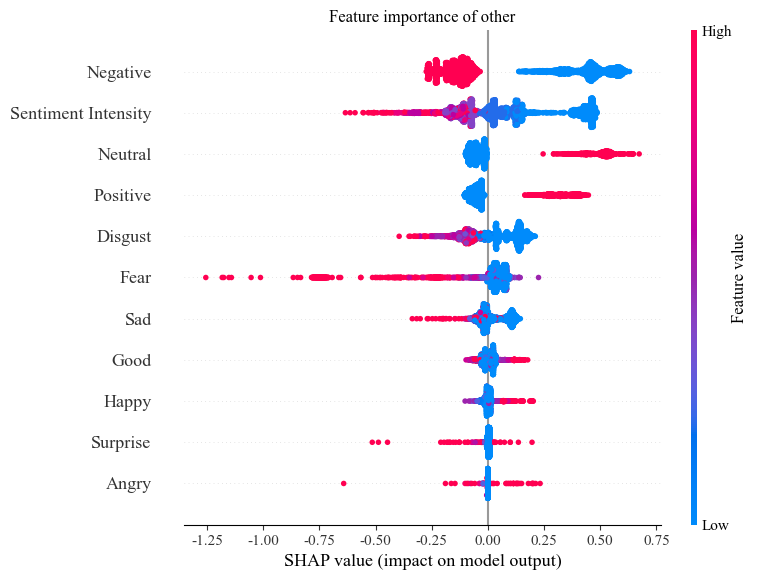


类别 'depression' 的特征重要性:
类别SHAP值形状: (4000, 11)


C:\Users\qy201\AppData\Local\Temp\ipykernel_10940\3302760734.py:242: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


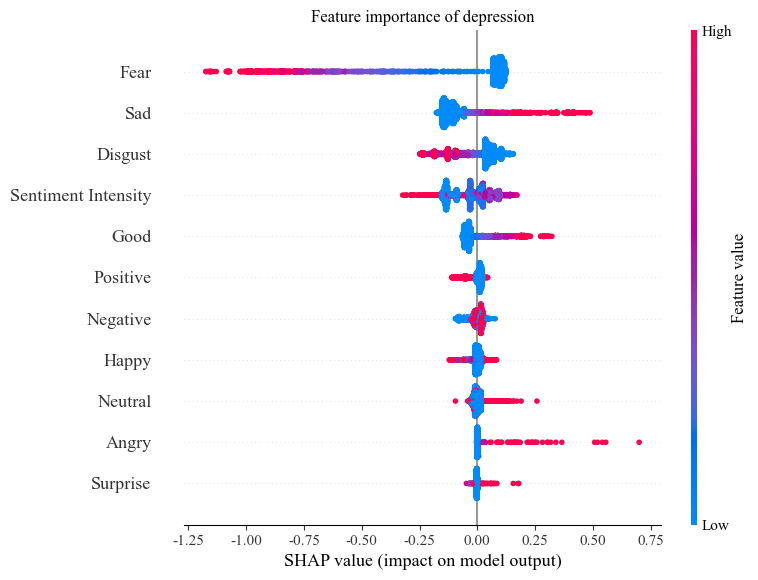


类别 'comorbidity' 的特征重要性:
类别SHAP值形状: (4000, 11)


C:\Users\qy201\AppData\Local\Temp\ipykernel_10940\3302760734.py:242: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


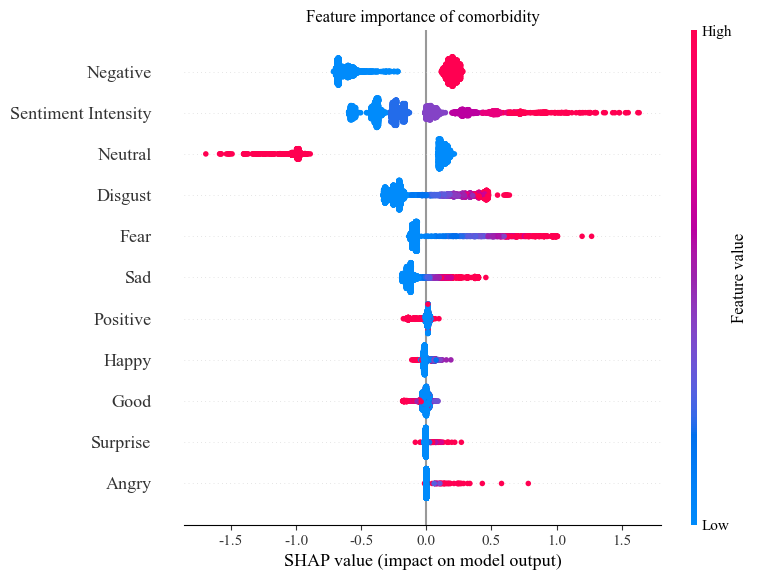


类别 'anxiety' 的特征重要性:
类别SHAP值形状: (4000, 11)


C:\Users\qy201\AppData\Local\Temp\ipykernel_10940\3302760734.py:242: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


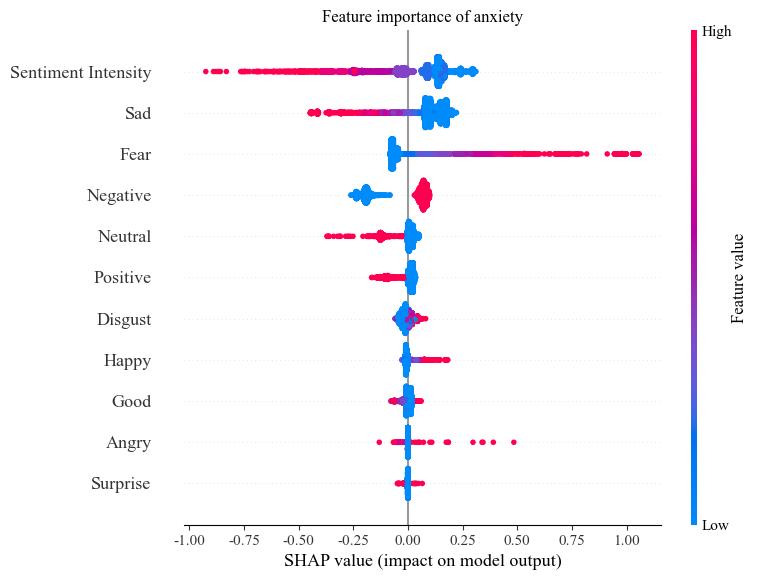

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 设置英文字体
# plt.rcParams['font.sans-serif'] = ['Times New Roman']

# 检查GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 读取数据，指定编码为utf-8-sig
X = pd.read_csv("E:/comorbidity/models/multi_features/emotion_sentiment_results.csv", encoding='utf-8-sig')  
y = pd.read_excel("E:/comorbidity/models/multi_features/Y.xlsx")  

# 2. 查看y的数据，假设标签列名为 '标签'
y = y['标签']

# 3. 标签编码（Label Encoding）
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 将标签转换为整数
print(y_encoded)

# 4. 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. 划分训练集、验证集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# 6. 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# 7. 创建数据加载器
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 8. 定义DNN模型 - 防过拟合优化版
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        # 简化网络结构，减少参数
        self.layer1 = nn.Linear(input_size, hidden_size // 2)  # 减少隐藏层大小
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)  # 添加批归一化
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)  # 适中的dropout
        self.layer2 = nn.Linear(hidden_size // 2, hidden_size // 4)  # 进一步减少
        self.bn2 = nn.BatchNorm1d(hidden_size // 4)
        self.dropout2 = nn.Dropout(0.4)  # 递增dropout
        self.layer3 = nn.Linear(hidden_size // 4, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.layer2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.layer3(out)
        return out

# 初始化模型参数
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(label_encoder.classes_)

# 加载之前保存的特定模型（例如seed=42的模型）
model_path = "E:/comorbidity/models/best_models/best_dnn_emotion_42.pth"  # 替换为您想要使用的模型路径
print(f"加载模型: {model_path}")

# 创建模型实例
model = DNN(input_size, hidden_size, num_classes).to(device)
# 加载模型权重
model.load_state_dict(torch.load(model_path))
model.eval()  # 设置为评估模式




print("模型加载完成，开始SHAP分析...")

# 修改SHAP分析的样本选择部分
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 设置英文字体

# 设置每个类别的样本数量
samples_per_class = 1000  # 4个类别 × 750 = 3000总样本
total_samples = samples_per_class * num_classes


# 从测试集中按类别进行分层抽样
sample_indices = []


# 获取类别名称
class_names = [str(name) for name in label_encoder.classes_]


# 对每个类别收集索引并抽样
for class_idx in range(num_classes):
    # 找到测试集中属于当前类别的所有样本索引
    class_indices = np.where(y_test == class_idx)[0]
    
    # 检查该类别是否有足够的样本
    if len(class_indices) < samples_per_class:
        print(f"警告: 类别 {class_names[class_idx]} 只有 {len(class_indices)} 个样本，小于所需的 {samples_per_class} 个")
        # 使用该类别所有样本
        selected = class_indices
    else:
        # 随机抽取指定数量的样本
        selected = np.random.choice(class_indices, samples_per_class, replace=False)
    
    sample_indices.extend(selected)

# 确保索引唯一
sample_indices = np.unique(sample_indices)
print(f"总共选择了 {len(sample_indices)} 个样本进行SHAP分析")

# 使用选定的索引获取样本数据
sample_data_np = X_test_tensor[sample_indices].cpu().numpy()
# 获取对应的标签（用于验证）
selected_labels = y_test[sample_indices]

# 验证每个类别的样本数量
for class_idx in range(num_classes):
    count = np.sum(selected_labels == class_idx)
    print(f"类别 {class_names[class_idx]} 的样本数量: {count}")

# 从训练集抽取背景样本（保持不变）
train_sample_size = 8000
np.random.seed(42)
train_indices = np.random.choice(len(X_train_tensor), train_sample_size, replace=False)
background_np = X_train_tensor[train_indices].cpu().numpy()

print(f"背景数据形状: {background_np.shape}")
print(f"样本数据形状: {sample_data_np.shape}")

# 定义预测函数（保持不变）
def predict_fn(x):
    model.eval()
    with torch.no_grad():
        tensor_x = torch.tensor(x, dtype=torch.float32).to(device)
        outputs = model(tensor_x)
        return outputs.cpu().numpy()

# 进行SHAP分析（保持不变）
explainer = shap.Explainer(predict_fn, background_np, seed=42)
shap_values = explainer(sample_data_np)

# 后续的特征名称映射和可视化部分保持不变...

# 获取特征名称和类别名称
feature_names = [str(name) for name in X.columns.tolist()]
# class_names = [str(name) for name in label_encoder.classes_]

# === 添加特征名称映射替换 ===
feature_name_mapping = {
    '负向': 'Negative',
    '中性': 'Neutral',
    '正向': 'Positive',
    '情感强度_归一化': 'Sentiment Intensity',
    '好': 'Good',
    '乐': 'Happy',
    '哀': 'Sad',
    '怒': 'Angry',
    '惧': 'Fear',
    '恶': 'Disgust',
    '惊': 'Surprise'
}

# === 添加类别名称映射替换 ===
feature_name_mapping2 = {
    '其他': 'other',
    '抑郁': 'depression',
    '焦虑': 'anxiety',
    '抑郁焦虑': 'comorbidity'
}

# 应用名称映射
feature_names = [feature_name_mapping.get(name, name) for name in feature_names]
class_names = [feature_name_mapping2.get(name, name) for name in class_names]

# 检查SHAP值结构
if isinstance(shap_values, list):
    print("检测到多输出SHAP值")
    for i, sv in enumerate(shap_values):
        print(f"输出{i}的SHAP值形状:", sv.shape)
elif hasattr(shap_values, 'values'):
    print("统一对象格式的SHAP值")
    print("SHAP值数组形状:", shap_values.values.shape)
    print("SHAP值数组维度:", shap_values.values.ndim)

# 可视化每个类别的特征重要性
for i, class_name in enumerate(class_names):
    print(f"\n类别 '{class_name}' 的特征重要性:")
    
    try:
        # 提取当前类别的SHAP值
        if isinstance(shap_values, list):
            class_shap = shap_values[i].values if hasattr(shap_values[i], 'values') else shap_values[i]
            print(f"类别SHAP值形状: {class_shap.shape}")
        else:
            # 对于统一对象格式，形状应为(n_samples, n_features, n_classes)
            if shap_values.values.ndim == 3:
                class_shap = shap_values.values[:, :, i]  # (n_samples, n_features)
                print(f"类别SHAP值形状: {class_shap.shape}")
            else:
                class_shap = shap_values.values  # 使用完整SHAP值
                print(f"使用完整SHAP值形状: {class_shap.shape}")
        
        # 条形图总结
        shap.summary_plot(
            class_shap,
            sample_data_np,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"Feature importance of {class_name}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"绘制类别 '{class_name}' 时出错: {str(e)}")
        plt.close()


绘制多类别特征重要性图...


C:\Users\qy201\AppData\Local\Temp\ipykernel_10940\2563040256.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


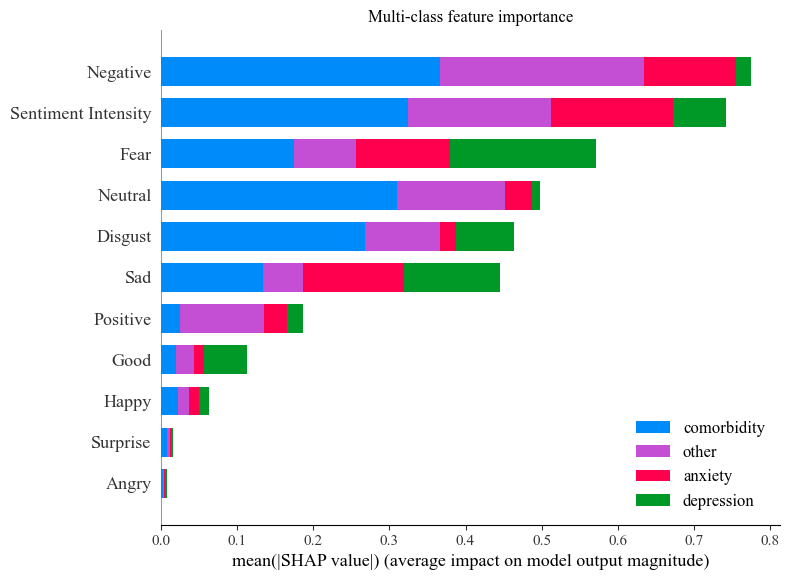

In [2]:

# 多类别特征重要性图
# ========================
print("\n绘制多类别特征重要性图...")
try:
    # 准备SHAP值数组
    if hasattr(shap_values, 'values'):
        # 统一对象格式
        if shap_values.values.ndim == 3:
            # 对于多类别分类，SHAP值形状为 (n_samples, n_features, n_classes)
            multi_class_shap = shap_values.values
        else:
            multi_class_shap = shap_values.values
    elif isinstance(shap_values, list):
        # 列表格式: 每个元素对应一个类别的SHAP值
        multi_class_shap = np.stack([sv.values if hasattr(sv, 'values') else sv for sv in shap_values], axis=-1)
    
    # 确保特征名数量匹配
    if len(feature_names) != sample_data_np.shape[1]:
        print(f"警告: 特征名数量({len(feature_names)})与数据特征维度({sample_data_np.shape[1]})不匹配")
        # 创建临时特征名
        temp_features = [f"特征_{i}" for i in range(sample_data_np.shape[1])]
    else:
        temp_features = feature_names
    
    # 绘制多类别特征重要性图
    shap.summary_plot(
        multi_class_shap,
        sample_data_np,
        feature_names=temp_features,
        class_names=class_names,  # 使用英文类别名称
        plot_type="bar",
        max_display=len(temp_features),  # 显示所有特征
        show=False
    )
    plt.title("Multi-class feature importance")
    plt.tight_layout()
    # plt.savefig("multi_class_feature_importance.png", dpi=300)
    plt.show()
except Exception as e:
    print(f"绘制多类别特征重要性图时出错: {str(e)}")
    import traceback
    traceback.print_exc()
    plt.close()


计算全局特征重要性...
转置后SHAP值形状: (4, 4000, 11)
全局特征重要性形状: (11,)
绘制全局特征重要性图...


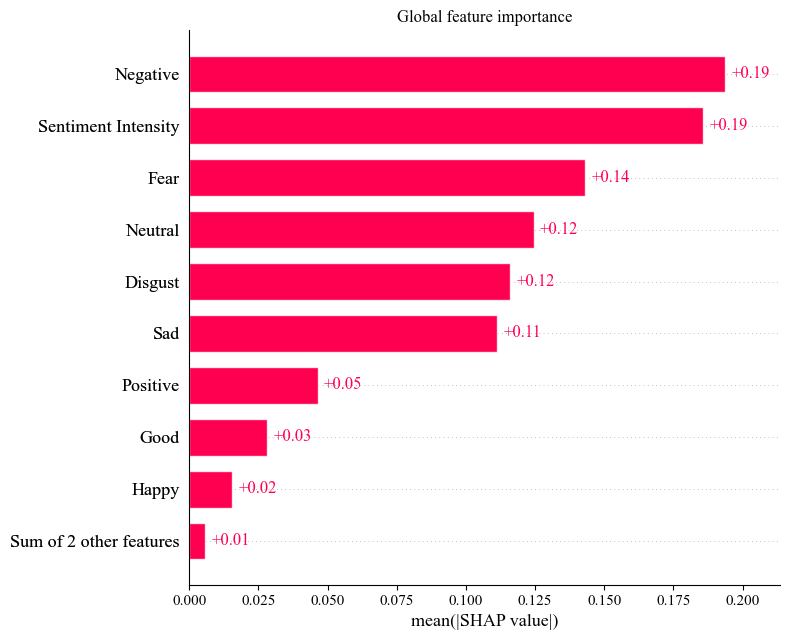


全局特征重要性排名:
1. Negative: 0.193645
2. Sentiment Intensity: 0.185630
3. Fear: 0.143024
4. Neutral: 0.124522
5. Disgust: 0.115902
6. Sad: 0.111198
7. Positive: 0.046464
8. Good: 0.028202
9. Happy: 0.015596
10. Surprise: 0.003816
11. Angry: 0.001851


In [3]:
# 全局特征重要性（合并所有类别）
try:
    print("\n计算全局特征重要性...")
    
    # 1. 收集所有类别的SHAP值
    if isinstance(shap_values, list):
        # 多输出格式：合并所有类别的SHAP值
        all_shap = [sv.values if hasattr(sv, 'values') else sv for sv in shap_values]
        combined_shap = np.stack(all_shap)  # (n_classes, n_samples, n_features)
        print(f"组合SHAP值形状: {combined_shap.shape}")
    else:
        # 统一对象格式
        if shap_values.values.ndim == 3:
            # (n_samples, n_features, n_classes) -> 转置为(n_classes, n_samples, n_features)
            combined_shap = np.transpose(shap_values.values, (2, 0, 1))
            print(f"转置后SHAP值形状: {combined_shap.shape}")
        else:
            combined_shap = shap_values.values  # 使用原始形状
            print(f"直接使用SHAP值形状: {combined_shap.shape}")
    
    # 2. 计算全局特征重要性
    # 取绝对值后按样本和类别平均
    global_shap = np.mean(np.abs(combined_shap), axis=(0, 1))  # (n_features,)
    print(f"全局特征重要性形状: {global_shap.shape}")
    
    # 3. 确保特征名数量匹配
    if len(feature_names) != len(global_shap):
        print(f"警告: 特征名数量({len(feature_names)})与全局特征重要性维度({len(global_shap)})不匹配")
        # 创建临时特征名
        temp_features = [f"特征_{i}" for i in range(len(global_shap))]
    else:
        temp_features = feature_names
    
    # 4. 创建SHAP解释对象用于绘图
    # 我们需要创建一个与全局重要性形状匹配的Explanation对象
    # 创建一个虚拟样本数据：形状为(1, n_features)
    dummy_data = np.zeros((1, len(global_shap)))
    
    # 创建Explanation对象
    explanation = shap.Explanation(
        values=np.expand_dims(global_shap, axis=0),  # (1, n_features)
        base_values=np.zeros(1),
        data=dummy_data,
        feature_names=temp_features
    )
    
    print("绘制全局特征重要性图...")
    # 5. 使用shap绘图
    shap.plots.bar(explanation, show=False)
    plt.title("Global feature importance")
    plt.tight_layout()
    plt.show()
    
    # 6. 额外：打印特征重要性排序
    sorted_idx = np.argsort(global_shap)[::-1]  # 从大到小排序
    print("\n全局特征重要性排名:")
    for i, idx in enumerate(sorted_idx):
        print(f"{i+1}. {temp_features[idx]}: {global_shap[idx]:.6f}")
        
except Exception as e:
    print(f"绘制全局特征重要性时出错: {str(e)}")
    import traceback
    traceback.print_exc()  # 打印完整错误堆栈
    plt.close()